# Example use of the Sonic module Linckii.jl

See https://julialang.org, https://juliadb.org and https://juliastats.org for reference.

In [1]:
import Pkg                      # package manager
Pkg.activate("..")              # Project.toml
Pkg.instantiate()               # https://julialang.github.io/Pkg.jl/v1.0/index.html

Activating environment at `~/Documents/Calendar/Work/Noda/Code/Sonic.jl/Project.toml`


In [2]:
import Dates, JuliaDB, Random, StatsPlots

┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273


In [3]:
using StatsPlots
ENV["GKSwstype"] = "100"
gr(fmt = :png)

Plots.GRBackend()

Get secret token,

In [21]:
include("../src/LinckiiSecrets.jl")
secret = LinckiiSecrets.keab

(dbname = "keab", endpoint = "https://canary.noda.se/~keab/api/v1", key = "e86d93131e6bc12ae701d036e696cf8b")

Get access token,

In [22]:
include("../src/Linckii.jl")
access = Linckii.get_access(secret)

(dbname = "keab", endpoint = "https://canary.noda.se/~keab/api/v1", key = "e86d93131e6bc12ae701d036e696cf8b")

`GET https://canary.noda.se/~keab/api/v1/nodes`,

In [23]:
@time site_nodes = Linckii.get_nodes(access)

 59.267685 seconds (55.63 M allocations: 3.602 GiB, 1.91% gc time)


Table with 279 rows, 8 columns:
Columns:
#  colname           type
───────────────────────────────────
1  node_public       Bool
2  node_name         Symbol
3  device_id         Int64
4  node_id           Int64
5  node_owner        Bool
6  node_enabled      Bool
7  sensor_ids        Array{Int64,1}
8  node_description  String

`GET https://canary.noda.se/~keab/api/v1/devices`,

In [24]:
@time site_devices = Linckii.get_devices(access)

 39.264030 seconds (31.21 M allocations: 2.162 GiB, 1.70% gc time)


Table with 11 rows, 3 columns:
protocol_id  device_name                     device_id
──────────────────────────────────────────────────────
1            Symbol("Kelp-IQHeat")           1
2            :Scout                          2
1            Symbol("Kelp-Basic")            4
5            Symbol("Weather-Forecast")      6
6            Symbol("Grid-Basic")            7
6            Symbol("Grid-Controller")       8
7            Symbol("Heat-Load-Forecast")    9
2            :CMa1Xw                         10
2            Symbol("EcoGuard Sensor")       11
2            :WEPTech                        12
8            Symbol("Flexibility-Forecast")  13

`GET https://canary.noda.se/~keab/api/v1/sensors`,

In [25]:
@time site_sensors = Linckii.get_sensors(access)

 56.426111 seconds (40.38 M allocations: 2.784 GiB, 1.67% gc time)


Table with 175 rows, 5 columns:
Columns:
#  colname             type
────────────────────────────────
1  sensor_unit         FreeUnits
2  sensor_name         Symbol
3  protocol_id         Int64
4  sensor_id           Int64
5  sensor_description  String

In [26]:
site = (nodes = site_nodes, devices = site_devices, sensors = site_sensors)
map(length, site)

(nodes = 279, devices = 11, sensors = 175)

Save site,

In [27]:
@time Linckii.savesite(secret; site...)

  3.495223 seconds (8.00 M allocations: 407.088 MiB, 4.24% gc time)


Load site,

In [28]:
@time site = Linckii.loadsite(secret, :nodes, :devices, :sensors)
map(length, site)

  0.108504 seconds (101.83 k allocations: 5.362 MiB)


(nodes = 279, devices = 11, sensors = 175)

Specify patterns,

In [29]:
patterns = Dict(
    4 => Dict(
        :meter_effect           => identity,
        :meter_heatenergy       => identity,
        :meter_primreturntemp   => identity,
        :meter_primsupplytemp   => identity,
        :meter_volume           => identity,
        :meter_volumeflow       => identity,
        :outdoortemp            => identity,
        :outdoortemp_offset     => identity,
    ),
    6 => Dict(
        :cloudiness             => identity,
        :outdoortemp            => identity,
        :wind_direction         => identity,
        :wind_speed             => identity,
    ),
)

Dict{Int64,Dict{Symbol,typeof(identity)}} with 2 entries:
  4 => Dict(:meter_primreturntemp=>identity,:meter_effect=>identity,:outdoortem…
  6 => Dict(:cloudiness=>identity,:outdoortemp=>identity,:wind_direction=>ident…

Get pattern nodes,

In [30]:
rs = JuliaDB.rows(Linckii.get_pattern_nodes(patterns; site...))
if true
    rs = [(node_id = 62, device_id = 4), (node_id = 93, device_id = 4)] # [rs[Random.rand(1 : end)]]
end
length(rs)

2

Save data,

In [31]:
dates = Dates.DateTime(2017, 12), Dates.DateTime(2019, 12)

2017-12-01T00:00:00:1 month:2019-12-01T00:00:00

In [21]:
@time for r in rs
    for sensor_name in keys(patterns[r.device_id])
        p = secret.target
        p = Linckii.dbpath(p, "data", r.node_id; db = sensor_name)
        if !isfile(p)
            try
                Linckii.savedata(access, r.node_id, sensor_name, dates)
                println("$(p): Done")
            catch e
                if typeof(e) <: InterruptException
                    rethrow(e)
                end
                println("$(p): $(e)")
            end
        end
    end
end

  0.028644 seconds (6.86 k allocations: 368.833 KiB)


Random choice,

In [22]:
r = rs[Random.rand(1 : end)]

(node_id = 93, device_id = 4)

In [23]:
sensor_names = collect(keys(patterns[r.device_id]))

8-element Array{Symbol,1}:
 :meter_primreturntemp
 :meter_effect        
 :outdoortemp         
 :meter_primsupplytemp
 :meter_volumeflow    
 :meter_volume        
 :outdoortemp_offset  
 :meter_heatenergy    

In [29]:
sensor_name = sensor_names[Random.rand(1 : end)]

:outdoortemp

Load data,

In [30]:
data = Linckii.loaddata(secret, r.node_id, sensor_name)

Table with 84069 rows, 3 columns:
datetime             variable      value
────────────────────────────────────────────
2018-02-14T12:58:57  :outdoortemp  4.14928
2018-02-14T13:08:57  :outdoortemp  4.09659
2018-02-14T13:18:57  :outdoortemp  4.09575
2018-02-14T13:28:57  :outdoortemp  4.09948
2018-02-14T13:38:57  :outdoortemp  4.10738
2018-02-14T13:48:57  :outdoortemp  4.13313
2018-02-14T13:58:58  :outdoortemp  4.43855
2018-02-14T14:08:57  :outdoortemp  4.77618
2018-02-14T14:18:57  :outdoortemp  4.74802
2018-02-14T14:28:57  :outdoortemp  4.44761
2018-02-14T14:38:57  :outdoortemp  4.0249
2018-02-14T14:48:57  :outdoortemp  3.95864
⋮
2019-11-30T22:18:55  :outdoortemp  -0.928536
2019-11-30T22:28:55  :outdoortemp  -0.912817
2019-11-30T22:39:00  :outdoortemp  -0.925861
2019-11-30T22:49:00  :outdoortemp  -0.943969
2019-11-30T22:59:00  :outdoortemp  -1.02741
2019-11-30T23:09:00  :outdoortemp  -1.08872
2019-11-30T23:19:00  :outdoortemp  -1.15112
2019-11-30T23:29:01  :outdoortemp  -1.18528
2019-11

Simple graphics,

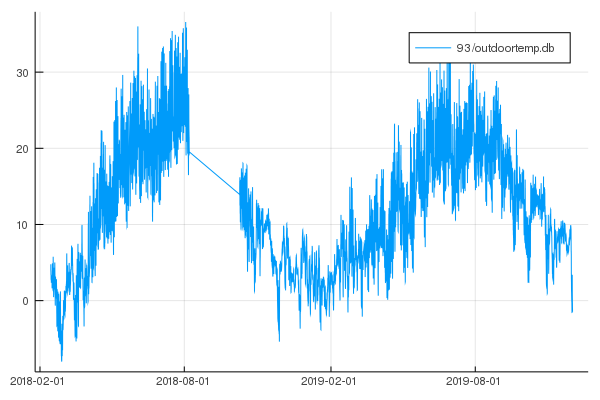

In [31]:
@df data plot(:datetime, :value, label = Linckii.dbpath(r.node_id; db = sensor_name))